This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU.

# todos:
* dropout
* L1/L2 regularization
* validation and AUC

In [1]:
%matplotlib inline
from __future__ import print_function, division
from io import open
import string
import re
import random
import sklearn 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data

use_cuda = torch.cuda.is_available()

import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

In [2]:
use_cuda

False

In [3]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the splitted training, valid and Test sets

def data_load_split_VT(seqFile = 'pytorch_ehr-master/pytorch_ehr-master/data/cerner/hospital_data/h143.visits', labelFile = 'pytorch_ehr-master/pytorch_ehr-master/data/cerner/hospital_data/h143.labels' , test_r=0.2 , valid_r=0.1):

    set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
    set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
    merged_set = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists

    # set random seed
    random.seed( 3 )
    
    dataSize = len(merged_set)
    nTest = int(test_r * dataSize)
    nValid = int(valid_r * dataSize)
    
    random.shuffle(merged_set)

    test_set = merged_set[:nTest]
    valid_set = merged_set[nTest:nTest+nValid]
    train_set = merged_set[nTest+nValid:]

    return train_set, valid_set, test_set

In [4]:
train_sl , valid_sl , test_sl = data_load_split_VT()

In [5]:
len(test_sl)

8545

In [6]:
class EHR_RNN(nn.Module):
    def __init__(self, input_size, hidden_size,embed_dim, n_layers=1,dropout_r=0.1):
        super(EHR_RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embed_dim = embed_dim
        self.dropout_r = dropout_r

#        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedBag = nn.EmbeddingBag(input_size, self.embed_dim,mode= 'sum')
        self.gru = nn.GRU(self.embed_dim, hidden_size, dropout= dropout_r )
        self.out = nn.Linear(self.hidden_size,1)
        self.sigmoid = nn.Sigmoid()


        
    def EmbedPatient_MB(self, seq_mini_batch): # x is a ehr_seq_tensor
        
        lp= len(max(seq_mini_batch, key=lambda xmb: len(xmb[1]))[1]) # max number of visitgs within mb ??? verify again
        #print ('longest',lp)
        tb= torch.FloatTensor(len(seq_mini_batch),lp,self.embed_dim) 
        lbt1= torch.FloatTensor(len(seq_mini_batch),1)

        for pt in range(len(seq_mini_batch)):
              
            lbt ,pt_visits =seq_mini_batch[pt]
            lbt1[pt] = torch.FloatTensor([[float(lbt)]])
            ml=(len(max(pt_visits, key=len))) ## getting the visit with max no. of codes ##the max number of visits for pts within the minibatch
            txs= torch.LongTensor(len(pt_visits),ml)
            
            b=0
            for i in pt_visits:
                pd=(0, ml-len(i))
                txs[b] = F.pad(torch.from_numpy(np.asarray(i)).view(1,-1),pd,"constant", 0).data
                b=b+1
            
            if use_cuda:
                txs=txs.cuda()
                
            emb_bp= self.embedBag(Variable(txs)) ### embed will be num_of_visits*max_num_codes*embed_dim 
            #### the embed Bag dim will be num_of_visits*embed_dim
            
            zp= nn.ZeroPad2d((0,0,0,(lp-len(pt_visits))))
            xzp= zp(emb_bp)
            tb[pt]=xzp.data

        tb= tb.permute(1, 0, 2) ### as my final input need to be seq_len x batch_size x input_size
        emb_m=Variable(tb)
        label_tensor = Variable(lbt1)

        if use_cuda:
                label_tensor = label_tensor.cuda()
                emb_m = emb_m.cuda()
        #print (label_tensor)        
        return emb_m , label_tensor

    def forward(self, input, hidden):
        
        x_in , lt = self.EmbedPatient_MB(input)
        
        for i in range(self.n_layers):
                output, hidden = self.gru(x_in, hidden) # input (seq_len, batch, input_size) need to check torch.nn.utils.rnn.pack_padded_sequence() 
                                                          #h_0 (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.

        output = self.sigmoid(self.out(output[0]))
        #print (output, lt)
        return output, lt

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [7]:

model = EHR_RNN(input_size=20000, hidden_size=128 ,embed_dim=128, dropout_r=0)

if use_cuda:
    model = model.cuda()

In [8]:
def train (mini_batch, criterion, optimizer):  
    
    hidden = model.initHidden()
    model.zero_grad()
    output , label_tensor = model(mini_batch,hidden)
    loss = criterion(output, label_tensor)
    loss.backward()
    optimizer.step()
   
    return output, loss.data[0]

In [9]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list of list
    result = []
    if use_cuda:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])).cuda() )
    # if use_cuda:
    #     return result.cuda()
    else:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])) )

    return result

In [10]:
# training all samples in random order
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)





In [11]:
def run_model_train(dataset,batch_size,learning_rate = 0.0001 ):
    
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_rate)
    #optimizer = optim.RMSprop (model.parameters())

    dataset.sort(key=lambda pt:len(pt[1])) 
   
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    print_every = 200#int(batch_size/2)
    plot_every = 1 #5
    iter=0
    n_batches = int(np.ceil(int(len(dataset)) / int(batch_size)))
    #print('number of Batches',n_batches)
    start = time.time()

    for index in random.sample(range(n_batches), n_batches):
            batch = dataset[index*batch_size:(index+1)*batch_size]
            output, loss = train(batch, criterion = nn.BCELoss(), optimizer = optimizer)
            #print (output)
            current_loss += loss
            iter +=1
            # Print iter number, loss, name and guess
            #if iter % print_every == 0:
            #       print('%d %d%% (%s) %.4f ' % ( iter, iter/ n_batches * 100, timeSince(start), loss))

            # Add current loss avg to list of losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
                
    return current_loss,all_losses


In [12]:
def calculate_auc(test_model, dataset, batch_size=200):

    n_batches = int(np.ceil(int(len(dataset)) / int(batch_size)))
    labelVec =[]
    y_hat= []
    hidden = model.initHidden()

    for index in range(n_batches):
            batch = dataset[index*batch_size:(index+1)*batch_size]
            output, label_t = model(batch,hidden)
            y_hat.extend(output.cpu().data.view(-1).numpy())
            labelVec.extend(label_t.cpu().data.view(-1).numpy())
    auc = roc_auc_score(labelVec, y_hat)
    #auc_plot (labelVec, y_hat)
  
    return auc

In [ ]:
def auc_plot(y_real, y_hat):

   fpr, tpr, _ = roc_curve(y_real,  y_hat)
   auc = roc_auc_score(y_real, y_hat)
   plt.plot(fpr,tpr,label="auc="+str(auc))
   plt.legend(loc=4)
   plt.show()

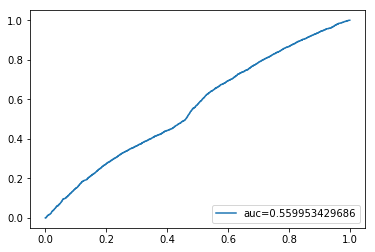

len labelVec, y_hat 29912 29912


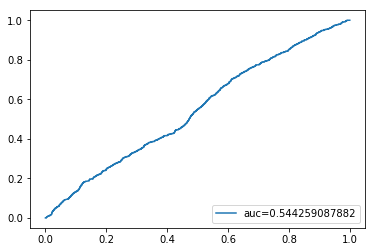

len labelVec, y_hat 8545 8545


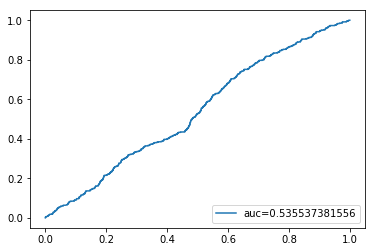

len labelVec, y_hat 4272 4272
Epoch  0  Train_auc : 0.559953429686  , Valid_auc :  0.535537381556  ,& Test_auc :  0.544259087882  Avg Loss:  0.45468030115


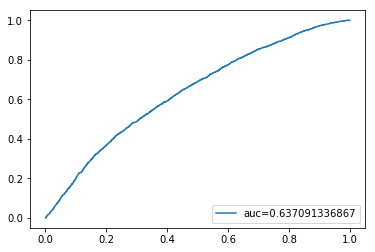

len labelVec, y_hat 29912 29912


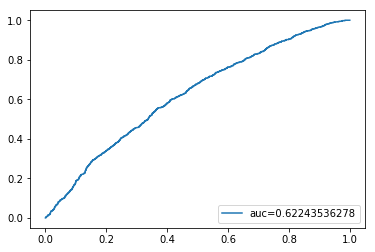

len labelVec, y_hat 8545 8545


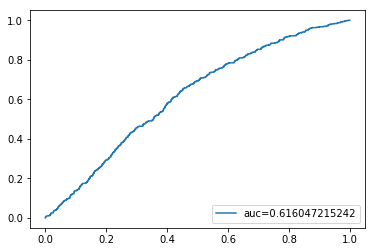

len labelVec, y_hat 4272 4272
Epoch  1  Train_auc : 0.637091336867  , Valid_auc :  0.616047215242  ,& Test_auc :  0.62243536278  Avg Loss:  0.368214623233


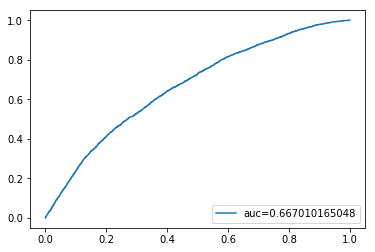

len labelVec, y_hat 29912 29912


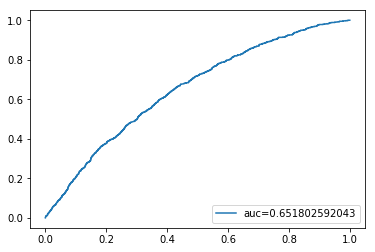

len labelVec, y_hat 8545 8545


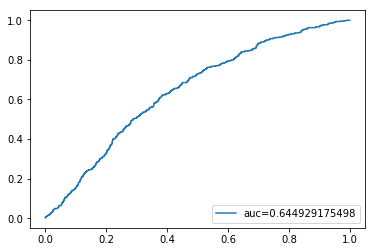

len labelVec, y_hat 4272 4272
Epoch  2  Train_auc : 0.667010165048  , Valid_auc :  0.644929175498  ,& Test_auc :  0.651802592043  Avg Loss:  0.355318933229


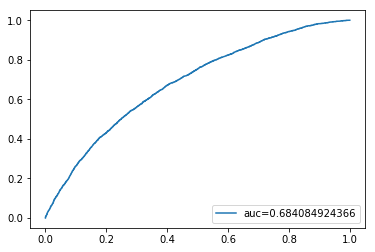

len labelVec, y_hat 29912 29912


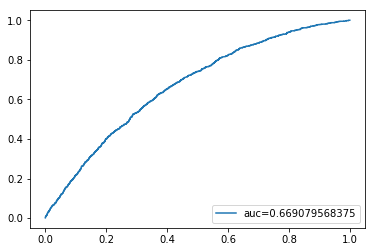

len labelVec, y_hat 8545 8545


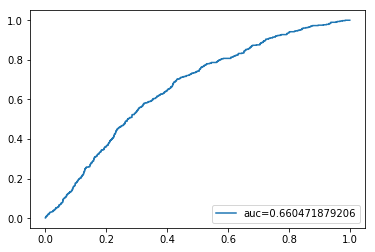

len labelVec, y_hat 4272 4272
Epoch  3  Train_auc : 0.684084924366  , Valid_auc :  0.660471879206  ,& Test_auc :  0.669079568375  Avg Loss:  0.34891473333


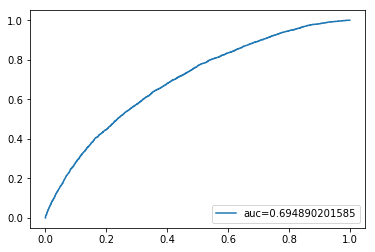

len labelVec, y_hat 29912 29912


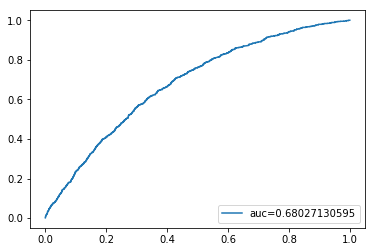

len labelVec, y_hat 8545 8545


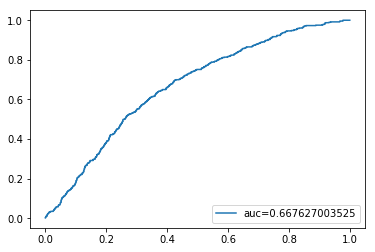

len labelVec, y_hat 4272 4272
Epoch  4  Train_auc : 0.694890201585  , Valid_auc :  0.667627003525  ,& Test_auc :  0.68027130595  Avg Loss:  0.344084626337


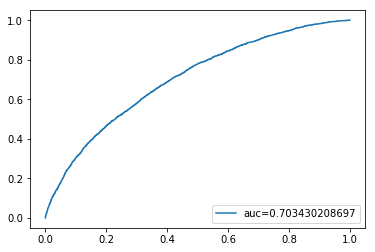

len labelVec, y_hat 29912 29912


In [ ]:
epochs=20
batch_size=200
current_loss_l=[]
all_losses_l=[]

for ep in range(epochs):
    #print ("Epoch ", ep )
    current_loss_la,all_losses_la = run_model_train(train_sl,batch_size)
    train_auc = calculate_auc(model,train_sl,batch_size)
    test_auc = calculate_auc(model,test_sl,batch_size)
    valid_auc = calculate_auc(model,valid_sl,batch_size)
    all_losses_l.append (all_losses_la)
    avg_loss = np.mean(all_losses_la)
    
    print ("Epoch ", ep," Train_auc :", train_auc, " , Valid_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss )
    
    current_loss_l.append(current_loss_la)


In [ ]:
all_losses_l

In [ ]:
for x_ep in all_losses_l:
    y_ep = np.mean(x_ep)
    print (y_ep)